# Import Library Kaggle dan Dataset

In [1]:
!pip install -q kaggle
from google.colab import files
import os

files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d rkuo2000/fer2013-clean
!unzip fer2013-clean.zip

Streaming output truncated to the last 5000 lines.
  inflating: FER2013_clean/train/sad/Training_65180660.jpg  
  inflating: FER2013_clean/train/sad/Training_65185815.jpg  
  inflating: FER2013_clean/train/sad/Training_65193650.jpg  
  inflating: FER2013_clean/train/sad/Training_65197439.jpg  
  inflating: FER2013_clean/train/sad/Training_6520336.jpg  
  inflating: FER2013_clean/train/sad/Training_65204985.jpg  
  inflating: FER2013_clean/train/sad/Training_65220319.jpg  
  inflating: FER2013_clean/train/sad/Training_6522916.jpg  
  inflating: FER2013_clean/train/sad/Training_65242339.jpg  
  inflating: FER2013_clean/train/sad/Training_65267116.jpg  
  inflating: FER2013_clean/train/sad/Training_65275626.jpg  
  inflating: FER2013_clean/train/sad/Training_6529266.jpg  
  inflating: FER2013_clean/train/sad/Training_65329617.jpg  
  inflating: FER2013_clean/train/sad/Training_65338712.jpg  
  inflating: FER2013_clean/train/sad/Training_65338797.jpg  
  inflating: FER2013_clean/train/sad/

# Path Dataset & Sorting Kelas yang Ada

In [2]:
train_dir = '/content/FER2013_clean/train'
test_dir = '/content/FER2013_clean/test'

labels = sorted(os.listdir(train_dir))
print("Kelas yang tersedia:", labels)

Kelas yang tersedia: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Import Libray yang Diperlukan

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Augmentasi Data

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
target_size = (48, 48)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Found 28656 images belonging to 7 classes.
Found 7168 images belonging to 7 classes.
Class weights: {0: np.float64(1.029088558500323), 1: np.float64(9.410837438423645), 2: np.float64(1.0009081383164513), 3: np.float64(0.5683346224787291), 4: np.float64(0.8253456221198157), 5: np.float64(0.8486140724946695), 6: np.float64(1.2930240952982583)}


# Membangun Model CNN

In [5]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam

input_shape = (48, 48, 1)
num_classes = len(labels)

model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,79

 Total params: 1,469,927 (5.61 MB)

 Trainable params: 1,469,031 (5.60 MB)

 Non-trainable params: 896 (3.50 KB)

# Compile Model

In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menambahkan Callbaks

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Training Model dengan Menambahkan Earlystopping

In [9]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1585 - loss: 6.4623

448/448 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.1584 - loss: 6.4611 - val_accuracy: 0.1304 - val_loss: 5.6720 - learning_rate: 1.0000e-04
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1582 - loss: 5.3850

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.1582 - loss: 5.3844 - val_accuracy: 0.2222 - val_loss: 4.5544 - learning_rate: 1.0000e-04
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1828 - loss: 4.3609

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.1829 - loss: 4.3604 - val_accuracy: 0.2086 - val_loss: 3.6881 - learning_rate: 1.0000e-04
Epoch 4/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1931 - loss: 3.5298

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.1931 - loss: 3.5291 - val_accuracy: 0.2917 - val_loss: 3.0276 - learning_rate: 1.0000e-04
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2220 - loss: 2.9537

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.2220 - loss: 2.9534 - val_accuracy: 0.3309 - val_loss: 2.5336 - learning_rate: 1.0000e-04
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2370 - loss: 2.5386

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.2370 - loss: 2.5384 - val_accuracy: 0.3595 - val_loss: 2.1759 - learning_rate: 1.0000e-04
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2643 - loss: 2.2629

448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.2643 - loss: 2.2628 - val_accuracy: 0.3605 - val_loss: 2.0431 - learning_rate: 1.0000e-04
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2883 - loss: 2.0824

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.2883 - loss: 2.0824 - val_accuracy: 0.3825 - val_loss: 1.8794 - learning_rate: 1.0000e-04
Epoch 9/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2980 - loss: 1.9406

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.2980 - loss: 1.9406 - val_accuracy: 0.4163 - val_loss: 1.7417 - learning_rate: 1.0000e-04
Epoch 10/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3222 - loss: 1.8782

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.3222 - loss: 1.8781 - val_accuracy: 0.4139 - val_loss: 1.6757 - learning_rate: 1.0000e-04
Epoch 11/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3321 - loss: 1.8126

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.3321 - loss: 1.8126 - val_accuracy: 0.4248 - val_loss: 1.6195 - learning_rate: 1.0000e-04
Epoch 12/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3554 - loss: 1.7487

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.3554 - loss: 1.7487 - val_accuracy: 0.4256 - val_loss: 1.5804 - learning_rate: 1.0000e-04
Epoch 13/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3638 - loss: 1.7114

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.3638 - loss: 1.7114 - val_accuracy: 0.4703 - val_loss: 1.4912 - learning_rate: 1.0000e-04
Epoch 14/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.3755 - loss: 1.6839 - val_accuracy: 0.4499 - val_loss: 1.5309 - learning_rate: 1.0000e-04
Epoch 15/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3927 - loss: 1.6258

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.3927 - loss: 1.6259 - val_accuracy: 0.4671 - val_loss: 1.4808 - learning_rate: 1.0000e-04
Epoch 16/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.4059 - loss: 1.6026 - val_accuracy: 0.4686 - val_loss: 1.4897 - learning_rate: 1.0000e-04
Epoch 17/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4125 - loss: 1.5819

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.4125 - loss: 1.5819 - val_accuracy: 0.4902 - val_loss: 1.4027 - learning_rate: 1.0000e-04
Epoch 18/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.4211 - loss: 1.5563 - val_accuracy: 0.4782 - val_loss: 1.4220 - learning_rate: 1.0000e-04
Epoch 19/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.4289 - loss: 1.5591 - val_accuracy: 0.4948 - val_loss: 1.4028 - learning_rate: 1.0000e-04
Epoch 20/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.4410 - loss: 1.5103 - val_accuracy: 0.4796 - val_loss: 1.4375 - learning_rate: 1.0000e-04
Epoch 21/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4448 - loss: 1.4853

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.4448 - loss: 1.4853 - val_accuracy: 0.4898 - val_loss: 1.4022 - learning_rate: 1.0000e-04
Epoch 22/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4513 - loss: 1.4902

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.4513 - loss: 1.4902 - val_accuracy: 0.5152 - val_loss: 1.3275 - learning_rate: 1.0000e-04
Epoch 23/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.4549 - loss: 1.5027 - val_accuracy: 0.5100 - val_loss: 1.3449 - learning_rate: 1.0000e-04
Epoch 24/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.4639 - loss: 1.4611 - val_accuracy: 0.5199 - val_loss: 1.3412 - learning_rate: 1.0000e-04
Epoch 25/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4708 - loss: 1.4422

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.4708 - loss: 1.4422 - val_accuracy: 0.5269 - val_loss: 1.3125 - learning_rate: 1.0000e-04
Epoch 26/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.4706 - loss: 1.4293 - val_accuracy: 0.5071 - val_loss: 1.3677 - learning_rate: 1.0000e-04
Epoch 27/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.4752 - loss: 1.4047 - val_accuracy: 0.5179 - val_loss: 1.3236 - learning_rate: 1.0000e-04
Epoch 28/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.4820 - loss: 1.3914 - val_accuracy: 0.5204 - val_loss: 1.3255 - learning_rate: 1.0000e-04
Epoch 29/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4799 - loss: 1.4016

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.4799 - loss: 1.4017 - val_accuracy: 0.5368 - val_loss: 1.2750 - learning_rate: 1.0000e-04
Epoch 30/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.4940 - loss: 1.3845 - val_accuracy: 0.5145 - val_loss: 1.3539 - learning_rate: 1.0000e-04
Epoch 31/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.4947 - loss: 1.3821 - val_accuracy: 0.5204 - val_loss: 1.3104 - learning_rate: 1.0000e-04
Epoch 32/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.4901 - loss: 1.3841 - val_accuracy: 0.5293 - val_loss: 1.2934 - learning_rate: 1.0000e-04
Epoch 33/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.4977 - loss: 1.3545 - val_accuracy: 0.5303 - val_loss: 1.3057 - learning_rate: 1.0000e-04
Epoch 34/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5026 - loss: 1.3484

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5026 - loss: 1.3484 - val_accuracy: 0.5523 - val_loss: 1.2453 - learning_rate: 1.0000e-04
Epoch 35/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.5062 - loss: 1.3446 - val_accuracy: 0.5370 - val_loss: 1.3074 - learning_rate: 1.0000e-04
Epoch 36/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5094 - loss: 1.3356 - val_accuracy: 0.5419 - val_loss: 1.2819 - learning_rate: 1.0000e-04
Epoch 37/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5196 - loss: 1.3130

448/448 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.5196 - loss: 1.3130 - val_accuracy: 0.5583 - val_loss: 1.2292 - learning_rate: 1.0000e-04
Epoch 38/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5104 - loss: 1.3275 - val_accuracy: 0.5527 - val_loss: 1.2531 - learning_rate: 1.0000e-04
Epoch 39/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5186 - loss: 1.2999

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.5186 - loss: 1.2999 - val_accuracy: 0.5617 - val_loss: 1.2220 - learning_rate: 1.0000e-04
Epoch 40/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5158 - loss: 1.3216

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5159 - loss: 1.3216 - val_accuracy: 0.5619 - val_loss: 1.2072 - learning_rate: 1.0000e-04
Epoch 41/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.5283 - loss: 1.2842 - val_accuracy: 0.5562 - val_loss: 1.2405 - learning_rate: 1.0000e-04
Epoch 42/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5253 - loss: 1.2813

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.5253 - loss: 1.2813 - val_accuracy: 0.5679 - val_loss: 1.2008 - learning_rate: 1.0000e-04
Epoch 43/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.5288 - loss: 1.2787 - val_accuracy: 0.5670 - val_loss: 1.2223 - learning_rate: 1.0000e-04
Epoch 44/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5215 - loss: 1.2747

448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.5215 - loss: 1.2747 - val_accuracy: 0.5769 - val_loss: 1.1804 - learning_rate: 1.0000e-04
Epoch 45/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5302 - loss: 1.2834

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5302 - loss: 1.2834 - val_accuracy: 0.5816 - val_loss: 1.1802 - learning_rate: 1.0000e-04
Epoch 46/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.5340 - loss: 1.2608 - val_accuracy: 0.5611 - val_loss: 1.2165 - learning_rate: 1.0000e-04
Epoch 47/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5361 - loss: 1.2549 - val_accuracy: 0.5617 - val_loss: 1.2072 - learning_rate: 1.0000e-04
Epoch 48/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5347 - loss: 1.2599 - val_accuracy: 0.5580 - val_loss: 1.2147 - learning_rate: 1.0000e-04
Epoch 49/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5425 - loss: 1.2524

448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5425 - loss: 1.2524 - val_accuracy: 0.5865 - val_loss: 1.1595 - learning_rate: 1.0000e-04
Epoch 50/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.5420 - loss: 1.2482 - val_accuracy: 0.5684 - val_loss: 1.2063 - learning_rate: 1.0000e-04


# Plot Hasil Training

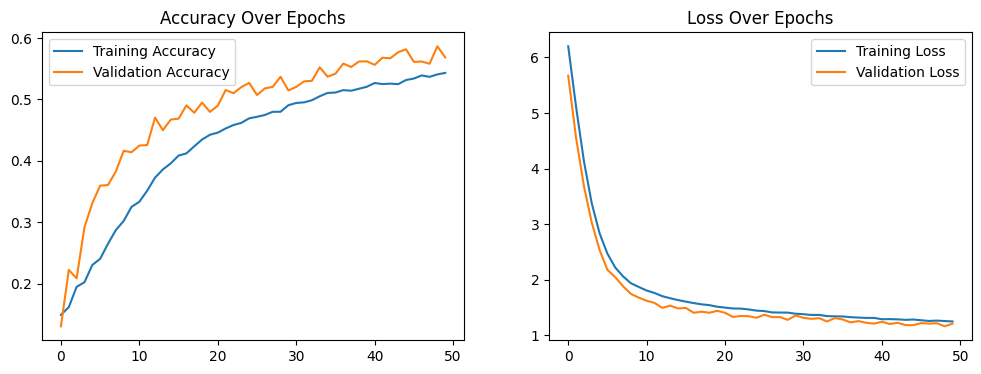

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5186 - loss: 1.2832


Test Accuracy: 0.5865
Test Loss: 1.1595
Model saved!


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

model.save('fer2013_cnn_improved.h5')
print("Model saved!")